# Prepare Twitter Data for Classification

In [2]:
### for file IO:
import os
import json
import sys
import sqlite3
import pickle as pkl

### for data analysis:
import numpy as np
import pandas as pd

### for plotting:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

### Others
import warnings
warnings.filterwarnings('ignore') # suppress warnings
from __future__ import print_function # use print as a function like in python3

## Load tweets from the database we've created

In [3]:
conn = sqlite3.connect('health.db')
c = conn.cursor()
test_sql = pd.read_sql_query("Select * from tweets",conn)
conn.close()
test_sql.head(10)

,tweet,id,screenName,isRT,rtCount,fCount
0,This #job might be a great fit for you: SOUS C...,851413077232803840,CompassJobBoard,0,0,1132
1,@SpeakerRyan Only if you believe Healthcare is...,851413060078231552,kjoosten56,0,0,15
2,"""Customer obsessed"" is my new fave way of thin...",851413058488594433,lesliebeard,0,1,231
3,RT @RAdamsDudleyMD: US healthcare=best? Yes. E...,851413044936802304,christophlane,0,46,2036
4,PRESS RELEASE » Emerging Healthcare IT Industr...,851413031837990912,OpineHEALTH,0,0,909
5,RT @JoyAnnReid: When they come back they'll tr...,851413029367549952,Mom0U812,0,3887,62
6,Healthcare Natural Language Processing (NLP) M...,851413026326679552,IoTBlogs,0,1,16208
7,RT @JoyAnnReid: When they come back they'll tr...,851413025152262148,jasonphuff,0,3887,162
8,PRESS RELEASE » Wireless Healthcare Market: Gl...,851413025018048515,OpineHEALTH,0,0,909
9,पेट दर्द का इलाज चुटकियों में |\n#onlinecg #he...,851413024959152128,Online_cg,0,0,214


# Exploratory Data Analysis

In [4]:
print ("Total number of tweets = {}".format(test_sql.shape[0]))

Total number of tweets = 634588


Clean up the data we'll use for training and testing our prediction algorithms:

In [5]:
# Remove duplicates based on both id and text of tweets
test_sql.drop_duplicates(['tweet'],inplace=True)
test_sql.drop_duplicates('id',inplace=True)
print ("Number of tweets after removing duplicates = {}".format(test_sql.shape[0]))

Number of tweets after removing duplicates = 308168


In [6]:
# Less than 1% of all collected tweets were from users with zero followers
print ("Tweets with zero followers = {}".format(sum(test_sql['fCount']==0)))

Tweets with zero followers = 1195


In [7]:
# Remove tweets with zero followers, since it's just a small fraction of total number of tweets.
test_sql_nof = test_sql[test_sql['fCount']>0]
print ("Total number of tweets remaining = {}".format(test_sql_nof.shape[0]))

Total number of tweets remaining = 306973


Tweets from users who already have a larger number of followers are expected to be retweeted more often. For this project, we want to focus on the content of tweets, not the number of followers. Thus, I normalized the retweet count by the number of followers to get a score, for classifying tweets as 'retweetable' or not.

In [8]:
# Create a new column (pctRT) to store rtCount/fCount
test_sql_nof['pctRT'] = test_sql_nof['rtCount']/test_sql_nof['fCount']
test_sql_nof.head(5)

,tweet,id,screenName,isRT,rtCount,fCount,pctRT
0,This #job might be a great fit for you: SOUS C...,851413077232803840,CompassJobBoard,0,0,1132,0.000000
1,@SpeakerRyan Only if you believe Healthcare is...,851413060078231552,kjoosten56,0,0,15,0.000000
2,"""Customer obsessed"" is my new fave way of thin...",851413058488594433,lesliebeard,0,1,231,0.004329
3,RT @RAdamsDudleyMD: US healthcare=best? Yes. E...,851413044936802304,christophlane,0,46,2036,0.022593
4,PRESS RELEASE » Emerging Healthcare IT Industr...,851413031837990912,OpineHEALTH,0,0,909,0.000000


Take a look at tweets with pctRT larger than (or equal to) 1. These are all retweets (indicated by 'RT' at the beginning of the tweets) or responses to an original tweet:

In [9]:
test_sql_nof[test_sql_nof['pctRT']>=1].head()

,tweet,id,screenName,isRT,rtCount,fCount,pctRT
5,RT @JoyAnnReid: When they come back they'll tr...,851413029367549952,Mom0U812,0,3887,62,62.693548
21,RT @JillDLawrence: Tennessee business owner: D...,851412992096964608,PattyLee3,0,41,18,2.277778
39,RT @JoyAnnReid: Puzder's argument: let us pay ...,851412869086359553,JessInTexas1,0,475,47,10.106383
45,RT @SAYoungLion: #ChrisHani died fighting for ...,851412836010033152,LeratoMcCow,0,712,180,3.955556
152,RT @blackbookpolls: Download 2017 Black Book H...,851412210949668864,Yaussi34,0,49,40,1.225000


In [10]:
# Only keep tweets where pctRT < 1 
test_sql_final = test_sql_nof[test_sql_nof['pctRT']<1]
print("Tweets remaining = {}".format((test_sql_final.shape[0])))

Tweets remaining = 305305


Look at the distribution of tweets based on how often they were retweeted. -- Most of them were not retweeted.

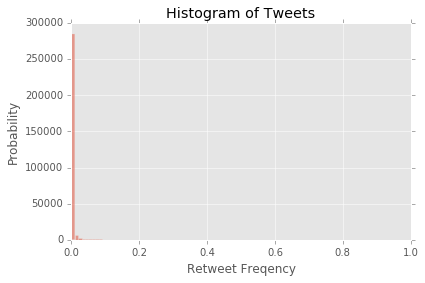

In [11]:
fig, ax = plt.subplots()
test_sql_final.pctRT.hist(ax=ax, bins=100, alpha=0.5, range=[0, 1])
#ax.set_xscale('log')
plt.xlabel('Retweet Freqency')
plt.ylabel('Probability')
plt.title('Histogram of Tweets')

# Save the plot
img = 'distribution.png'
plt.tight_layout()
plt.savefig(img, format='png',  dpi=300)

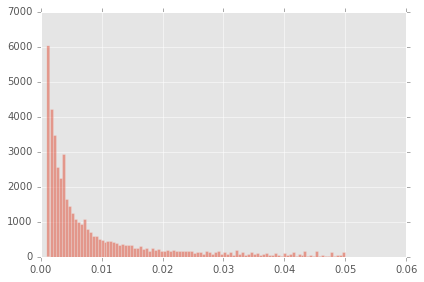

In [12]:
fig, ax = plt.subplots()
test_sql_final.pctRT.hist(ax=ax, bins=100, alpha=0.5, range=[0.001, 0.05])
#ax.set_xscale('log')
img = 'distribution_zoom.png'
plt.tight_layout()
plt.savefig(img, format='png',  dpi=300)

# Define Classification Criterion

Construct categorical tweets:
-- 0: Not Retweeted; 
-- 1: Retweeted 
with a threshold (0.5%), i.e., classifying a tweet as 'retweetable' if pctRT is above threshold (set to 0.005). 

In [18]:
# Store the classification label in a new column called 'RTBinary'.
test_sql_final['RTBinary'] = (test_sql_final['pctRT']>0.005)

In [19]:
test_sql_final.head()

,tweet,id,screenName,isRT,rtCount,fCount,pctRT,RTBinary
0,This #job might be a great fit for you: SOUS C...,851413077232803840,CompassJobBoard,0,0,1132,0.000000,False
1,@SpeakerRyan Only if you believe Healthcare is...,851413060078231552,kjoosten56,0,0,15,0.000000,False
2,"""Customer obsessed"" is my new fave way of thin...",851413058488594433,lesliebeard,0,1,231,0.004329,False
3,RT @RAdamsDudleyMD: US healthcare=best? Yes. E...,851413044936802304,christophlane,0,46,2036,0.022593,True
4,PRESS RELEASE » Emerging Healthcare IT Industr...,851413031837990912,OpineHEALTH,0,0,909,0.000000,False


Notice the class imbalance. About 9.5% tweets that are classified as 'retweetable':

In [20]:
np.mean(test_sql_final['RTBinary'])

0.094905094905094911

In [21]:
df = pd.DataFrame({"tweet": test_sql_final.tweet, "RTbinary": test_sql_final.RTBinary })
df.head()

,RTbinary,tweet
0,False,This #job might be a great fit for you: SOUS C...
1,False,@SpeakerRyan Only if you believe Healthcare is...
2,False,"""Customer obsessed"" is my new fave way of thin..."
3,True,RT @RAdamsDudleyMD: US healthcare=best? Yes. E...
4,False,PRESS RELEASE » Emerging Healthcare IT Industr...


Save the data frame as a pickle file so that we can load it in later python sessions to try different classification algorithms.

In [17]:
df.to_pickle('healthcare_RTbinary_pandasDF.pkl')